In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def solver(solver_step, t_start, y_start, funcs, dt=1e-2):
    t = t_start
    y = y_start.copy()
    res = [y]
    print('Start solve by: ', solver_step.__name__)
    while y[1] >= 0.0:
        #print(y)
        y = solver_step(dt, t, y, funcs)
        res.append(y)
        
        t = t + dt
        
        print('.', end='')
    print('Solved')    
    return t, np.array(res)

def euler_koshi_step(dt, t, y, funcs):
    y1 = np.zeros(len(funcs))
    ny = np.zeros(len(funcs))
    for (i, f) in enumerate(funcs):
        y1[i] = y[i] + dt * f(t, y)
    
    for (i, f) in enumerate(funcs):
        ny[i] = y[i] + dt * (f(t, y) + f(t + dt, y1)) / 2.0
    
    return ny

def rk_4_step(dt, t, y, funcs):
    sz = len(funcs)
    ny = np.zeros((sz,), dtype=np.float64)#[None] * sz
    
    two = float(2.0)
    
    k1 = np.array([dt * f(t, y) for f in funcs], dtype=np.float64)
    y1 = y + k1 / two #np.array([(y[i] + k1[i] / 2.0) for i in range(sz) ])
    #print(y1, (y + k1 / 2.0))
    t1 = (t + dt / two)
    
    k2 = np.array([dt * f(t1, y1) for f in funcs], dtype=np.float64)
    y2 = y + k2 / two #[(y[i] + k2[i] / two) for i in range(sz) ] #
    t2 = t1
    
    k3 = np.array([dt * f(t2, y2) for f in funcs], dtype=np.float64)
    y3 = y + k3 #[(y[i] + k3[i]) for i in range(sz) ]
    t3 = (t + dt)
    
    k4 = np.array([dt * f(t3, y3) for f in funcs], dtype=np.float64)
    
    for (i, f) in enumerate(funcs):
        ny[i] = y[i] + ( k1[i] + k4[i] + two * (k2[i] + k3[i]) ) / float(6.0)
    return ny

<h1>White Dwarf</h1>

0.10357441686512864
[3.33305886e-05 9.99972552e-02]
Start solve by:  rk_4_step
.....................................Solved
Start solve by:  euler_koshi_step
......................................Solved
3.8426108656962743


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


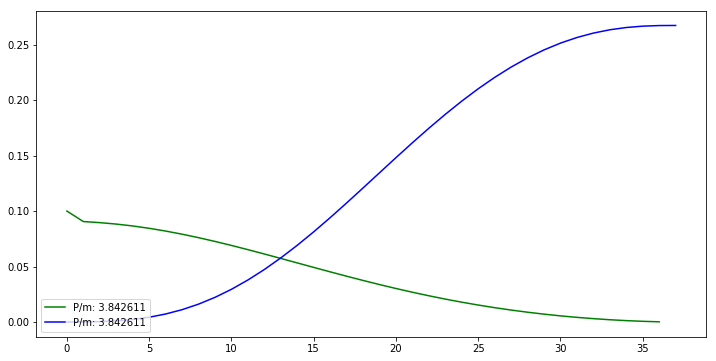

In [7]:
def psi(p):
    #print(p)
    
    x = np.power(p, 2.0/float(3.0), dtype=np.float64)
#    if np.isnan(x):
#        return np.inf
    #x2 = np.power(x, 2)
    return x / 3.0 / np.sqrt(1 + x)

funcs = [
    lambda r, y: y[1] * r**2, # dm/dr = p * r^2
    lambda r, y: -y[0] * y[1] / r**2 / psi(y[1]), # dp/dr = -m * p / psi / r^2
]

Pc = 1e-1

dr = 1.0/float(3.0) * np.power(3e-3 / float(Pc), 1.0/float(3.0))
print(dr)

r0 = dr / float(10.0)

P0 = Pc - 1.0/float(6.0) * np.power(Pc * r0, 2) / psi(Pc)

m0 = Pc/float(3.0) * np.power(P0, 3)

y0 = np.array([m0, P0], dtype=np.float64)

print(y0)

R_rk4, result_rk4 = solver(rk_4_step, r0, y0, funcs=funcs, dt=dr)

R_euler, result_ek = solver(euler_koshi_step, r0, y0, funcs=funcs, dt=dr)

#print(np.array(result_rk4) - np.array(result_ek[:-1]))
#print(result_ek, "\n\n", result_rk4)

print(R_rk4)

plt.figure(figsize=(12, 6))
plt.plot(range(len(result_rk4[:,1])), result_rk4[:,1], color='green', label='P/m: {:f}'.format(R_rk4))
plt.plot(range(len(result_rk4[:,0])), result_rk4[:,0], color='blue', label='P/m: {:f}'.format(R_rk4))

#plt.plot(result_ek[:,0], result_ek[:,1], color='orange', label='P/m euler: {:f}'.format(R_euler))

#plt.plot(rk4_res_x, rk4_res_y, color='green', label='rk_4_step')
plt.legend(loc="lower left")
plt.show()
